In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import f_oneway, chi2_contingency, pearsonr, ttest_ind
import io, sys, re
pd.set_option('display.float_format', lambda x: f'{x:,.3f}')
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/DATA MINING/datakelulusanmahasiswa.csv'
df = pd.read_csv(path, sep=';', engine='python')

Mounted at /content/drive


In [ ]:
def to_upper_snake(s):
    s = s.strip()
    s = re.sub(r'\s+', '_', s)
    s = s.replace('.', '_').replace('-', '_')
    return s.upper()
df.columns = [to_upper_snake(c) for c in df.columns]
print('Kolom setelah normalisasi:', list(df.columns))

num_like = [c for c in df.columns if re.search(r'IPK|IPS|UMUR|SKS|NILAI|SEMESTER|LAMA|TAHUN|ANGKATAN|USIA', c)]
for c in num_like:
    if df[c].dtype == 'object':
        df[c] = (df[c].astype(str)
                      .str.replace(',', '.', regex=False)
                      .str.replace('%','', regex=False)
                 )
        df[c] = pd.to_numeric(df[c], errors='coerce')

print('\nTipe data setelah konversi kandidat numerik:')
print(df[num_like].dtypes if num_like else 'Tidak ada kandidat numerik terdeteksi')

target = None
for cand in df.columns:
    if re.search(r'KELULUSAN|LULUS|TEPAT|GRADU', cand):
        target = cand
        break
print('\nTarget terdeteksi:', target)
if target is None:
    raise ValueError('Tidak menemukan kolom target (mis. STATUS_KELULUSAN). Harap ganti pencarian kata kunci di atas sesuai dataset Anda.')

df[target] = df[target].astype(str).str.strip()
print('Nilai unik target:', df[target].unique())

drop_cols = [c for c in df.columns if re.search(r'NIM|NAMA|ID', c)]
df_model = df.drop(columns=drop_cols, errors='ignore').copy()
df_model.head()

Kolom setelah normalisasi: ['NAMA', 'JENIS_KELAMIN', 'STATUS_MAHASISWA', 'UMUR', 'STATUS_NIKAH', 'IPS_1', 'IPS_2', 'IPS_3', 'IPS_4', 'IPS_5', 'IPS_6', 'IPS_7', 'IPS_8', 'IPK', 'STATUS_KELULUSAN']

Tipe data setelah konversi kandidat numerik:
UMUR       int64
IPS_1    float64
IPS_2    float64
IPS_3    float64
IPS_4    float64
IPS_5    float64
IPS_6    float64
IPS_7    float64
IPS_8    float64
IPK      float64
dtype: object

Target terdeteksi: STATUS_KELULUSAN
Nilai unik target: ['TERLAMBAT' 'TEPAT']


,JENIS_KELAMIN,STATUS_MAHASISWA,UMUR,STATUS_NIKAH,IPS_1,IPS_2,IPS_3,IPS_4,IPS_5,IPS_6,IPS_7,IPS_8,IPK,STATUS_KELULUSAN
0,PEREMPUAN,BEKERJA,28,BELUM MENIKAH,2.760,2.800,3.200,3.170,2.980,3.000,3.030,0.000,3.070,TERLAMBAT
1,PEREMPUAN,MAHASISWA,32,BELUM MENIKAH,3.000,3.300,3.140,3.140,2.840,3.130,3.250,0.000,3.170,TERLAMBAT
2,PEREMPUAN,BEKERJA,29,BELUM MENIKAH,3.500,3.300,3.700,3.290,3.530,3.720,3.730,0.000,3.540,TERLAMBAT
3,PEREMPUAN,MAHASISWA,27,BELUM MENIKAH,3.170,3.410,3.610,3.360,3.480,3.630,3.460,0.000,3.410,TERLAMBAT
4,PEREMPUAN,BEKERJA,29,BELUM MENIKAH,2.900,2.890,3.300,2.850,2.980,3.000,3.080,0.000,3.090,TERLAMBAT


Shape: (379, 15)

Missing values per kolom:
IPS_8               7
IPK                 3
NAMA                0
UMUR                0
STATUS_NIKAH        0
JENIS_KELAMIN       0
STATUS_MAHASISWA    0
IPS_2               0
IPS_1               0
IPS_3               0
IPS_4               0
IPS_6               0
IPS_5               0
IPS_7               0
STATUS_KELULUSAN    0
dtype: int64

Kolom numerik: ['UMUR', 'IPS_1', 'IPS_2', 'IPS_3', 'IPS_4', 'IPS_5', 'IPS_6', 'IPS_7', 'IPS_8', 'IPK']
Kolom kategorik: ['JENIS_KELAMIN', 'STATUS_MAHASISWA', 'STATUS_NIKAH', 'STATUS_KELULUSAN']


,count,mean,std,min,25%,50%,75%,max
UMUR,379.000,25.955,3.397,22.000,24.000,25.000,27.000,50.000
IPS_1,379.000,2.854,0.413,0.330,2.600,2.860,3.100,3.790
IPS_2,379.000,2.812,0.474,0.500,2.550,2.850,3.105,3.960
IPS_3,379.000,2.901,0.589,0.160,2.550,2.980,3.325,3.960
IPS_4,379.000,2.782,0.648,0.000,2.460,2.860,3.200,3.910
IPS_5,379.000,2.782,0.593,0.200,2.480,2.850,3.205,3.880
IPS_6,379.000,2.877,0.634,0.000,2.590,3.000,3.315,4.000
IPS_7,379.000,2.531,0.757,0.000,2.150,2.610,3.110,3.910
IPS_8,372.000,1.272,1.401,0.000,0.000,0.750,2.750,4.000
IPK,376.000,2.933,0.460,0.870,2.748,3.010,3.220,3.850


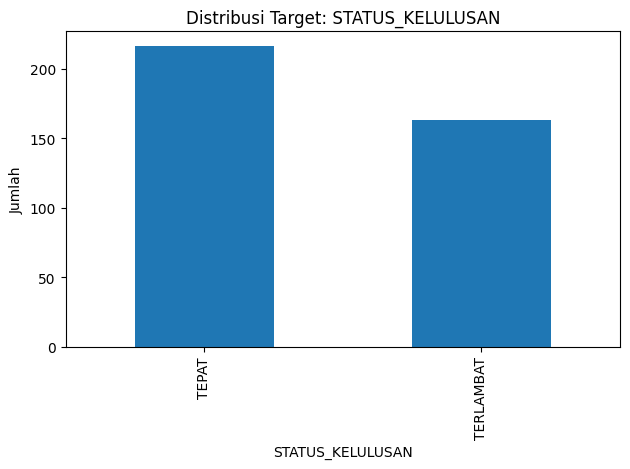

In [ ]:
print('Shape:', df.shape)
print('\nMissing values per kolom:')
print(df.isna().sum().sort_values(ascending=False).head(20))

num_cols = df_model.select_dtypes(include='number').columns.tolist()
cat_cols = [c for c in df_model.columns if c not in num_cols]
print('\nKolom numerik:', num_cols)
print('Kolom kategorik:', cat_cols)

display(df_model[num_cols].describe().T if num_cols else 'Tidak ada kolom numerik')

plt.figure()
df[target].value_counts().plot(kind='bar')
plt.title(f'Distribusi Target: {target}')
plt.ylabel('Jumlah')
plt.tight_layout()
plt.show()

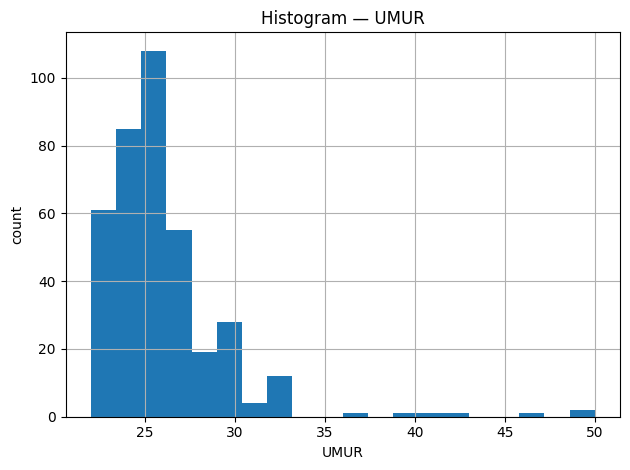

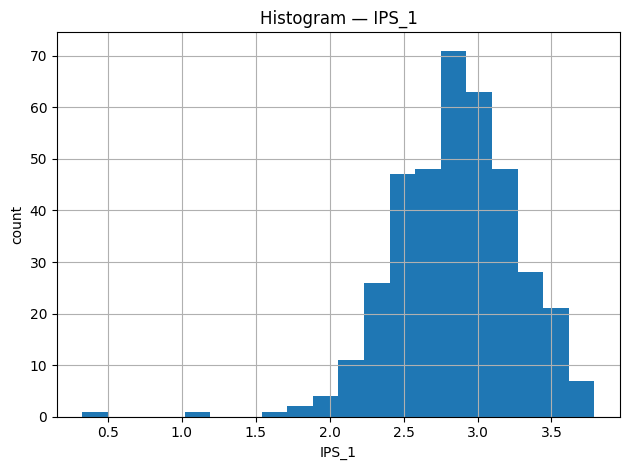

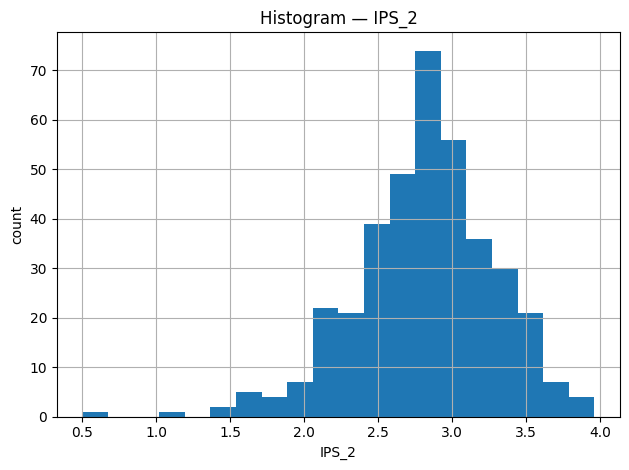

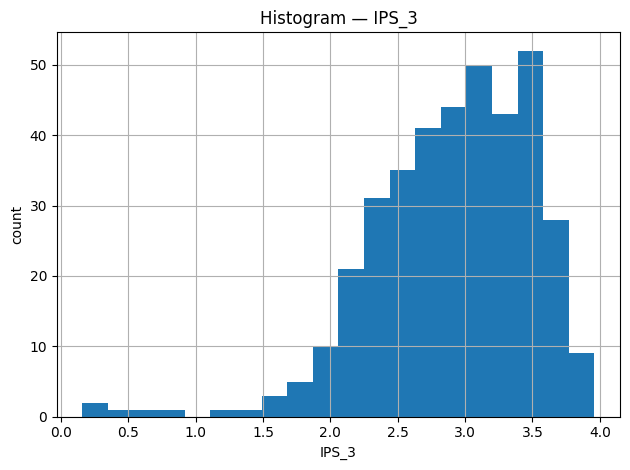

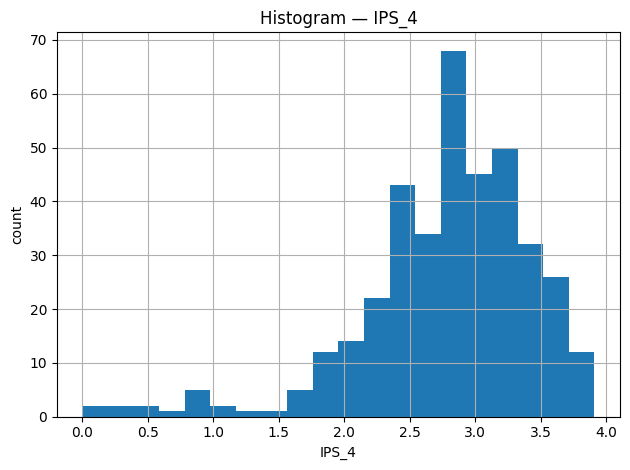

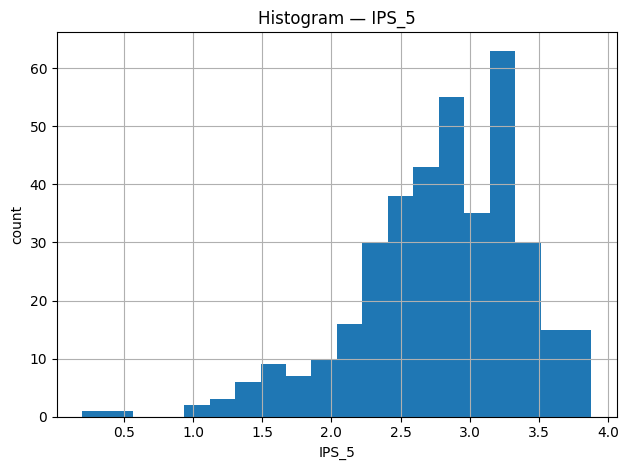

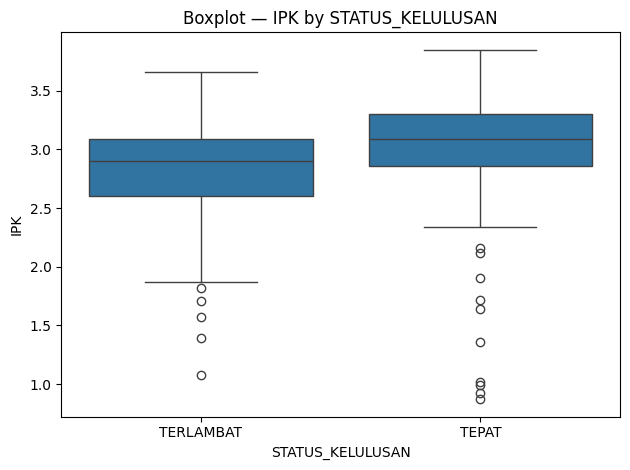

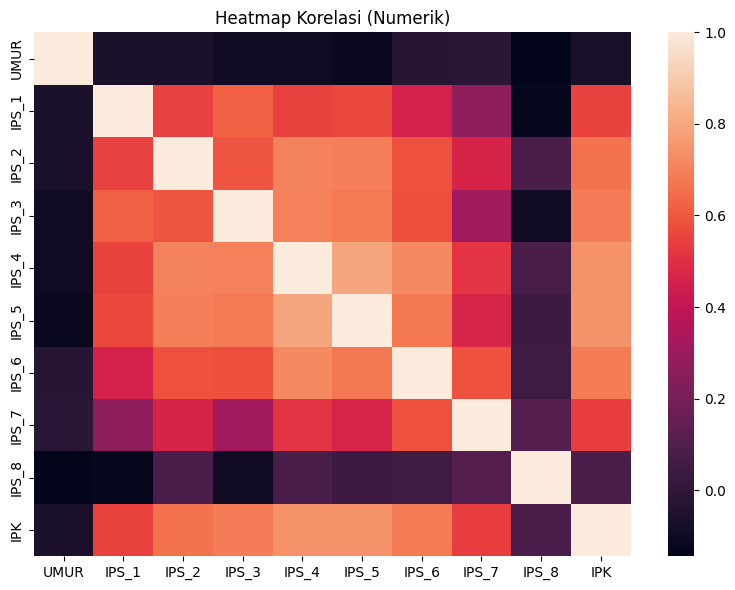

In [ ]:
to_plot = [c for c in num_cols if re.search(r'IPK|UMUR|IPS', c)][:6] or num_cols[:6]
for c in to_plot:
    plt.figure()
    df_model[c].hist(bins=20)
    plt.title(f'Histogram — {c}')
    plt.xlabel(c)
    plt.ylabel('count')
    plt.tight_layout()
    plt.show()

ipk_like = [c for c in num_cols if re.fullmatch(r'IPK', c) or 'IPK' in c]
if ipk_like:
    col_ipk = ipk_like[0]
    plt.figure()
    sns.boxplot(data=df_model, x=target, y=col_ipk)
    plt.title(f'Boxplot — {col_ipk} by {target}')
    plt.tight_layout()
    plt.show()

if len(num_cols) >= 2:
    plt.figure(figsize=(8,6))
    corr = df_model[num_cols].corr(numeric_only=True)
    sns.heatmap(corr, annot=False)
    plt.title('Heatmap Korelasi (Numerik)')
    plt.tight_layout()
    plt.show()

In [ ]:
ipk_like = [c for c in num_cols if 'IPK' in c]
if ipk_like:
    col_ipk = ipk_like[0]
    groups = [g[col_ipk].dropna().values for _, g in df_model.groupby(target)]
    if len(groups) == 2:
        t, p = ttest_ind(groups[0], groups[1], equal_var=False)
        print(f'T-test IPK antar kelompok {target}: t={t:.3f}, p={p:.2e}')
        print('Keputusan:', 'Signifikan' if p<0.05 else 'Tidak signifikan')
    elif len(groups) > 2:
        F, p = f_oneway(*groups)
        print(f'ANOVA IPK antar kelompok {target}: F={F:.3f}, p={p:.2e}')
        print('Keputusan:', 'Signifikan' if p<0.05 else 'Tidak signifikan')
else:
    print('Kolom IPK tidak ditemukan atau bukan numerik.')

sex_col = None
for c in df_model.columns:
    if re.search(r'JENIS_KELAMIN|SEX|GENDER', c):
        sex_col = c; break
if sex_col is not None:
    ct = pd.crosstab(df_model[sex_col], df_model[target])
    chi2, p, dof, exp = chi2_contingency(ct)
    print(f'Chi-Square {sex_col} vs {target}: chi2={chi2:.3f}, p={p:.2e}, dof={dof}')
    print('Keputusan:', 'Ada asosiasi signifikan' if p<0.05 else 'Tidak ada asosiasi signifikan')
    display(ct)
else:
    print('Kolom jenis kelamin tidak ditemukan.')

T-test IPK antar kelompok STATUS_KELULUSAN: t=4.707, p=3.57e-06
Keputusan: Signifikan
Chi-Square JENIS_KELAMIN vs STATUS_KELULUSAN: chi2=3.579, p=5.85e-02, dof=1
Keputusan: Tidak ada asosiasi signifikan


STATUS_KELULUSAN,TEPAT,TERLAMBAT
JENIS_KELAMIN,,
LAKI - LAKI,124,110
PEREMPUAN,92,53


Akurasi: 88.4%

Classification Report:
               precision    recall  f1-score   support

       TEPAT       0.92      0.87      0.90        54
   TERLAMBAT       0.84      0.90      0.87        41

    accuracy                           0.88        95
   macro avg       0.88      0.89      0.88        95
weighted avg       0.89      0.88      0.88        95



/tmp/ipython-input-165913778.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[c].fillna(mean_val, inplace=True)
/tmp/ipython-input-165913778.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df

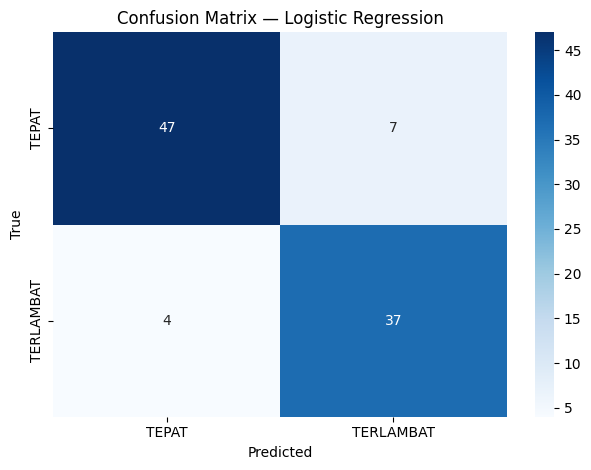

In [ ]:
y = df_model[target]
X = df_model.drop(columns=[target])

X_enc = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X_enc, y, test_size=0.25, random_state=42,
    stratify=y if y.nunique() > 1 else None
)

for c in X_train.columns:
    if X_train[c].dtype in ["float64", "int64"]:
        mean_val = X_train[c].mean()
        X_train[c].fillna(mean_val, inplace=True)
        X_test[c].fillna(mean_val, inplace=True)
    else:
        mode_val = X_train[c].mode()[0] if not X_train[c].mode().empty else "Unknown"
        X_train[c].fillna(mode_val, inplace=True)
        X_test[c].fillna(mode_val, inplace=True)

num_idx = X_train.select_dtypes(include='number').columns
scaler = StandardScaler()
X_train[num_idx] = scaler.fit_transform(X_train[num_idx])
X_test[num_idx]  = scaler.transform(X_test[num_idx])

multi = 'multinomial' if y.nunique() > 2 else 'auto'
clf = LogisticRegression(max_iter=2000, multi_class=multi)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f'Akurasi: {acc*100:.1f}%')
print('\nClassification Report:\n', classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=sorted(y.unique()))

plt.figure()
sns.heatmap(
    pd.DataFrame(cm, index=sorted(y.unique()), columns=sorted(y.unique())),
    annot=True, fmt='d', cmap='Blues'
)
plt.title('Confusion Matrix — Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()



=== KNN ===
Akurasi: 87.37%
              precision    recall  f1-score   support

       TEPAT       0.89      0.89      0.89        54
   TERLAMBAT       0.85      0.85      0.85        41

    accuracy                           0.87        95
   macro avg       0.87      0.87      0.87        95
weighted avg       0.87      0.87      0.87        95



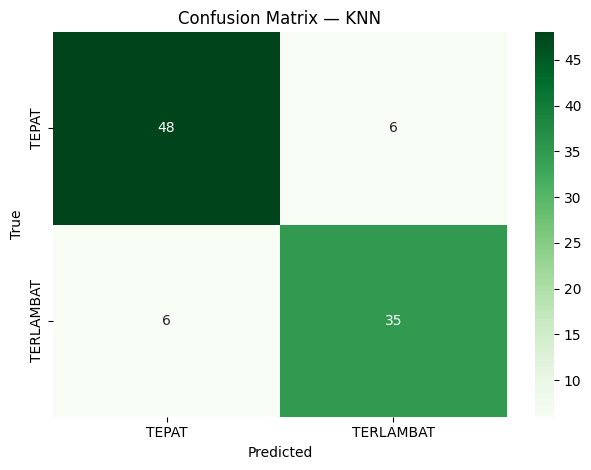


=== SVM ===
Akurasi: 89.47%
              precision    recall  f1-score   support

       TEPAT       0.96      0.85      0.90        54
   TERLAMBAT       0.83      0.95      0.89        41

    accuracy                           0.89        95
   macro avg       0.89      0.90      0.89        95
weighted avg       0.90      0.89      0.90        95



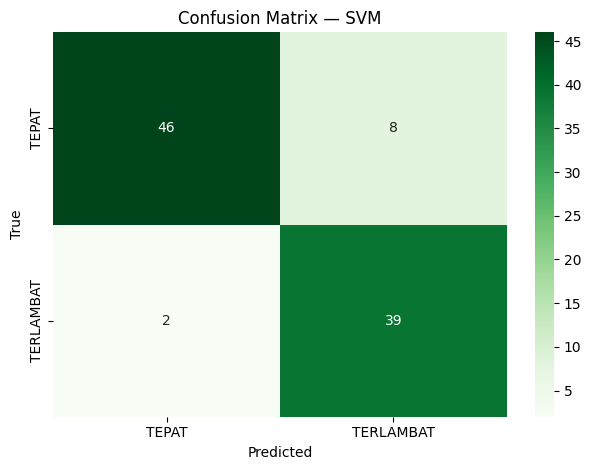


=== Random Forest ===
Akurasi: 92.63%
              precision    recall  f1-score   support

       TEPAT       0.94      0.93      0.93        54
   TERLAMBAT       0.90      0.93      0.92        41

    accuracy                           0.93        95
   macro avg       0.92      0.93      0.93        95
weighted avg       0.93      0.93      0.93        95



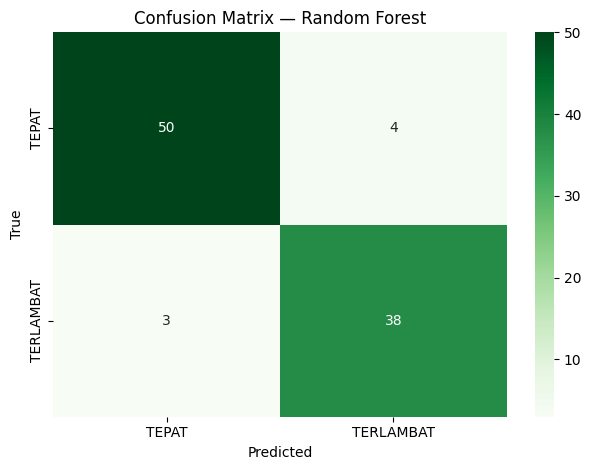

In [ ]:
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC(kernel='rbf', probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42)
}

models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC(kernel='rbf', probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n=== {name} ===")
    print(f"Akurasi: {acc*100:.2f}%")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred, labels=sorted(y.unique()))
    plt.figure()
    sns.heatmap(
        pd.DataFrame(cm, index=sorted(y.unique()), columns=sorted(y.unique())),
        annot=True, fmt='d', cmap='Greens'
    )
    plt.title(f'Confusion Matrix — {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

In [ ]:
_df = None
for cand in ['df', 'df_model']:
    if cand in globals():
        _df = globals()[cand].copy()
        break
assert _df is not None, "Tidak ditemukan variabel df/df_model. Jalankan cell load data terlebih dahulu."

# ---- 1) Util: cari kolom dengan pola nama umum ----
cols = [c for c in _df.columns]
def find_col(patterns, cols=cols):
    pat = re.compile(patterns, flags=re.I)
    for c in cols:
        if pat.search(c):
            return c
    return None

col_ipk    = find_col(r'\bIPK\b')
col_ips    = find_col(r'\bIPS\b')
col_gender = find_col(r'JENIS.*KELAMIN|GENDER|SEX')
col_target = find_col(r'STATUS.*KELULUSAN|KELULUSAN|STATUS$|TARGET')

print("Deteksi kolom:")
print("  IPK          :", col_ipk)
print("  IPS          :", col_ips)
print("  JENIS_KELAMIN:", col_gender)
print("  TARGET       :", col_target)

Deteksi kolom:
  IPK          : IPK
  IPS          : None
  JENIS_KELAMIN: JENIS_KELAMIN
  TARGET       : STATUS_KELULUSAN


In [ ]:
print("\n=== INFO DATA ===")
print(_df.info())
print("\n=== DESCRIPTIVE STATS (NUMERIK) ===")
display(_df.describe(include=[np.number]).T)

print("\n=== DESCRIPTIVE STATS (KATEGORIK) ===")
display(_df.describe(include=['object', 'category']).T)

print("\n=== NILAI HILANG PER KOLOM ===")
na_cnt = _df.isna().sum().sort_values(ascending=False)
display(na_cnt)

print("\n=== JUMLAH DUPLIKAT BARIS ===")
print(_df.duplicated().sum())


=== INFO DATA ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379 entries, 0 to 378
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   NAMA              379 non-null    object 
 1   JENIS_KELAMIN     379 non-null    object 
 2   STATUS_MAHASISWA  379 non-null    object 
 3   UMUR              379 non-null    int64  
 4   STATUS_NIKAH      379 non-null    object 
 5   IPS_1             379 non-null    float64
 6   IPS_2             379 non-null    float64
 7   IPS_3             379 non-null    float64
 8   IPS_4             379 non-null    float64
 9   IPS_5             379 non-null    float64
 10  IPS_6             379 non-null    float64
 11  IPS_7             379 non-null    float64
 12  IPS_8             372 non-null    float64
 13  IPK               376 non-null    float64
 14  STATUS_KELULUSAN  379 non-null    object 
dtypes: float64(9), int64(1), object(5)
memory usage: 44.5+ KB
None

=== DESC

,count,mean,std,min,25%,50%,75%,max
UMUR,379.000,25.955,3.397,22.000,24.000,25.000,27.000,50.000
IPS_1,379.000,2.854,0.413,0.330,2.600,2.860,3.100,3.790
IPS_2,379.000,2.812,0.474,0.500,2.550,2.850,3.105,3.960
IPS_3,379.000,2.901,0.589,0.160,2.550,2.980,3.325,3.960
IPS_4,379.000,2.782,0.648,0.000,2.460,2.860,3.200,3.910
IPS_5,379.000,2.782,0.593,0.200,2.480,2.850,3.205,3.880
IPS_6,379.000,2.877,0.634,0.000,2.590,3.000,3.315,4.000
IPS_7,379.000,2.531,0.757,0.000,2.150,2.610,3.110,3.910
IPS_8,372.000,1.272,1.401,0.000,0.000,0.750,2.750,4.000
IPK,376.000,2.933,0.460,0.870,2.748,3.010,3.220,3.850



=== DESCRIPTIVE STATS (KATEGORIK) ===


,count,unique,top,freq
NAMA,379,376,SRI LESTARI,2
JENIS_KELAMIN,379,2,LAKI - LAKI,234
STATUS_MAHASISWA,379,2,MAHASISWA,246
STATUS_NIKAH,379,2,BELUM MENIKAH,371
STATUS_KELULUSAN,379,2,TEPAT,216



=== NILAI HILANG PER KOLOM ===


,0
IPS_8,7
IPK,3
NAMA,0
UMUR,0
STATUS_NIKAH,0
JENIS_KELAMIN,0
STATUS_MAHASISWA,0
IPS_2,0
IPS_1,0
IPS_3,0



=== JUMLAH DUPLIKAT BARIS ===
0


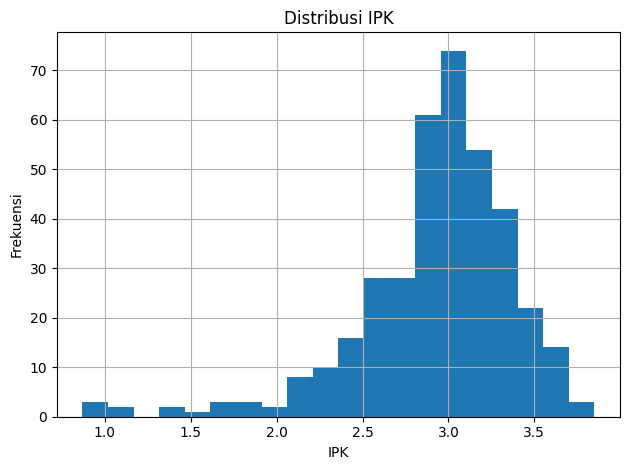

In [ ]:
num_cols = _df.select_dtypes(include=[np.number]).columns.tolist()
to_plot = [c for c in [col_ipk, col_ips] if c in num_cols]
if not to_plot:
    to_plot = num_cols[:4]  # fallback maksimal 4 kolom numerik

for c in to_plot:
    plt.figure()
    _df[c].hist(bins=20)
    plt.title(f"Distribusi {c}")
    plt.xlabel(c)
    plt.ylabel("Frekuensi")
    plt.tight_layout()
    plt.show()

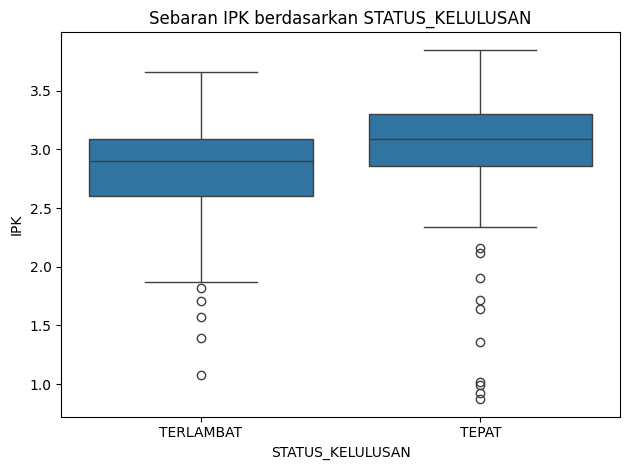

In [ ]:
if col_target and col_target in _df.columns:
    for c in to_plot:
        plt.figure()
        sns.boxplot(data=_df, x=col_target, y=c)
        plt.title(f"Sebaran {c} berdasarkan {col_target}")
        plt.tight_layout()
        plt.show()

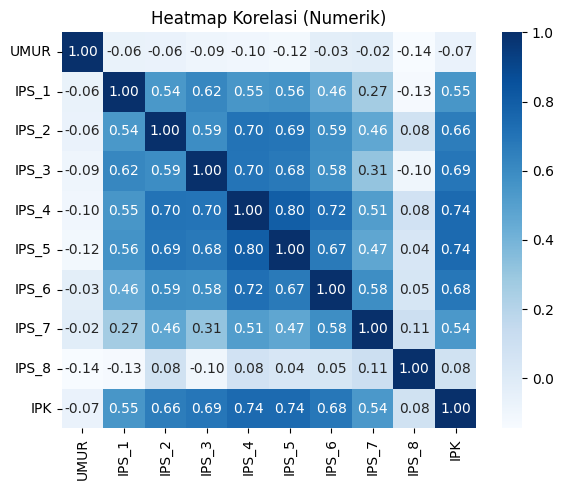

In [ ]:
if len(num_cols) >= 2:
    plt.figure(figsize=(6,5))
    corr = _df[num_cols].corr(method='pearson')
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='Blues')
    plt.title("Heatmap Korelasi (Numerik)")
    plt.tight_layout()
    plt.show()

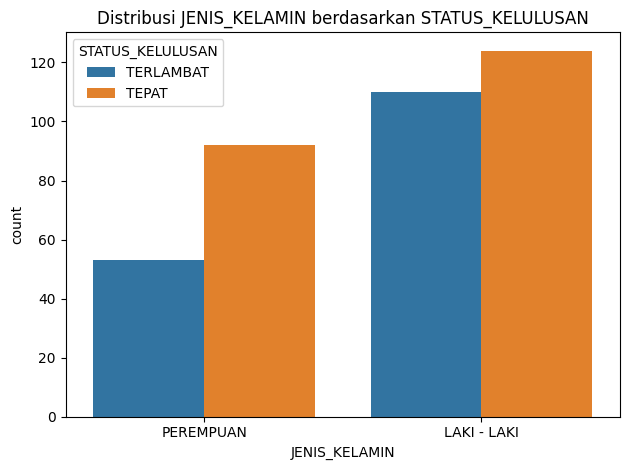

In [ ]:
if col_gender and col_target and (col_gender in _df.columns) and (col_target in _df.columns):
    plt.figure()
    sns.countplot(data=_df, x=col_gender, hue=col_target)
    plt.title(f"Distribusi {col_gender} berdasarkan {col_target}")
    plt.tight_layout()
    plt.show()

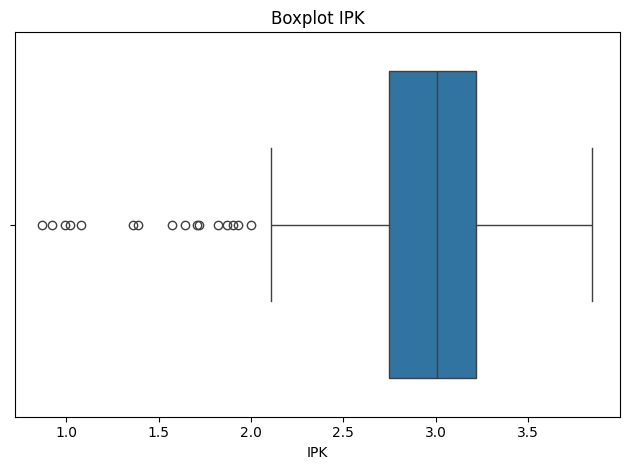

In [ ]:
for c in to_plot:
    plt.figure()
    sns.boxplot(x=_df[c])
    plt.title(f"Boxplot {c}")
    plt.tight_layout()
    plt.show()

In [ ]:
summary_points = []
if col_ipk:
    summary_points.append(f"- Distribusi {col_ipk}: mayoritas berada pada rentang kuantil: "
                          f"Q1={_df[col_ipk].quantile(0.25):.2f}, Median={_df[col_ipk].median():.2f}, Q3={_df[col_ipk].quantile(0.75):.2f}")
if col_ips:
    summary_points.append(f"- Rata-rata {col_ips}: {_df[col_ips].mean():.2f}, Std: {_df[col_ips].std():.2f}")
summary_points.append(f"- Missing values terbanyak: {na_cnt.index[0]} = {int(na_cnt.iloc[0])}" if len(na_cnt)>0 else "- Tidak ada missing values")
if len(num_cols) >= 2:
    top_pair = corr.abs().where(np.triu(np.ones(corr.shape), k=1).astype(bool)).stack().sort_values(ascending=False).head(1)
    if len(top_pair):
        (a,b), val = top_pair.index[0], float(top_pair.iloc[0])
        summary_points.append(f"- Korelasi numerik terkuat: {a} vs {b} = {val:.2f}")

print for s in summary_points:
    print(s)

SyntaxError: invalid syntax (ipython-input-3735931429.py, line 14)